# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
d_type='processed'     # 'processed', 'synthetic'
video_d=True            # Video = True , Image = False 
test_data,number_data_points= False,500

t_btw_frm=0.05

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   
     

# CNN

### GENERATE TRAIN DATA

In [4]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,recs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


### CHECK 1

In [5]:
rec_elm='I70'
idx=recs.index(rec_elm)
y_train[idx]

1.0

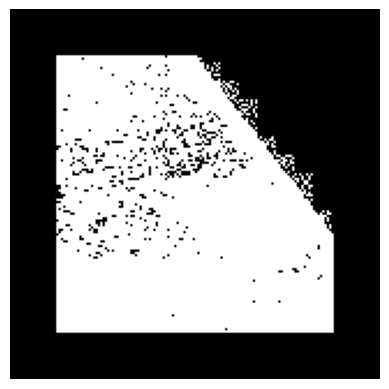

In [6]:
fig_lib.vid_show(x_train[idx],t_btw_frm=t_btw_frm)

In [7]:
if test_data:

    total_data_points=len(y_train)
    test_len=total_data_points-number_data_points
    
    Xx_train=x_train[0:number_data_points]
    Yy_train=y_train[0:number_data_points]
    recs=recs[0:number_data_points]

else:

    Xx_train=x_train
    Yy_train=y_train


## DATA SHUFFLE

In [8]:
idx_permut = np.random.permutation(len(Xx_train))
Xx_train,Yy_train=Xx_train[idx_permut],Yy_train[idx_permut]
recs=list(np.take(recs, idx_permut))


### CHECK 2

In [9]:
rec_elm='I70'
idx=recs.index(rec_elm)
print(idx,Yy_train[idx])

650 1.0


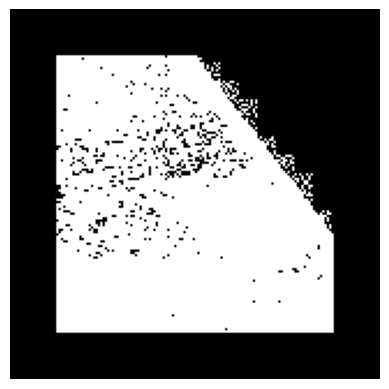

In [10]:
fig_lib.vid_show(Xx_train[idx],t_btw_frm=t_btw_frm)

## DATA SPLIT

In [11]:
# X_train,Y_train,X_eval,Y_eval


test_size=0.2


In [12]:

X_train, X_eval, Y_train, Y_eval = train_test_split(Xx_train, Yy_train, test_size=test_size, shuffle=False) #,random_state=42)

print('Train data:',len(Y_train),'Evaluation data:',len(Y_eval))
if test_data:print('Test_len:',test_len)

Train data: 648 Evaluation data: 162


 Train data shape: (648, 40, 160, 160, 1)  Validation data shape: (162, 40, 160, 160, 1)


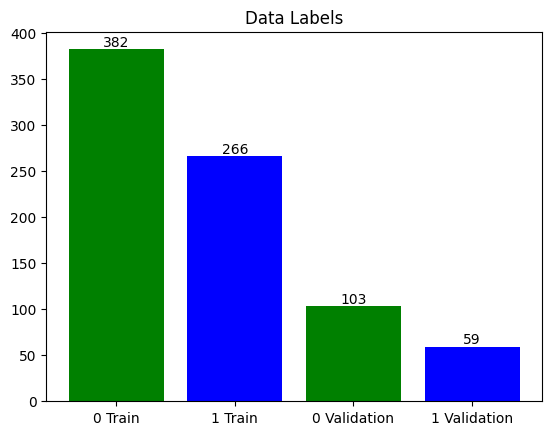

In [13]:
# check data

zeros_count = np.sum(Y_train == 0)
ones_count = np.sum(Y_train == 1)
zeros_count_val = np.sum(Y_eval == 0)
ones_count_val = np.sum(Y_eval == 1)

labels = ['0 Train', '1 Train','0 Validation', '1 Validation']
print(' Train data shape:', np.shape(X_train),' Validation data shape:', np.shape(X_eval))

plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['green', 'blue','green', 'blue'])

for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Data Labels')
plt.show()

### PARAMETERS

In [14]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D


In [15]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epch=9


### MODEL

In [16]:
gc.collect()

37782

In [17]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',input_shape=(max_frm_n, HEIGHT, WIDTH, 1)),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Dropout(0.2),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 158, 158, 16   448       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 19, 79, 79, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 77, 77, 32)    4640      
                                                                 
 dropout (Dropout)           (None, 19, 77, 77, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 9, 38, 38, 32)     0         
 g3D)                                                            
                                                       

In [18]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

In [19]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)            


### TRAINNING

In [20]:
history =model.fit(X_train, Y_train, epochs=epch, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/9


21/21 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.5787
Epoch 1: val_loss improved from inf to 0.68615, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
21/21 [==============================] - 51s 2s/step - loss: 0.7082 - accuracy: 0.5787 - val_loss: 0.6861 - val_accuracy: 0.6605
Epoch 2/9


c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.6096
Epoch 2: val_loss improved from 0.68615 to 0.64037, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
21/21 [==============================] - 40s 2s/step - loss: 0.6666 - accuracy: 0.6096 - val_loss: 0.6404 - val_accuracy: 0.7099
Epoch 3/9
21/21 [==============================] - ETA: 0s - loss: 0.6318 - accuracy: 0.6373
Epoch 3: val_loss improved from 0.64037 to 0.60813, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
21/21 [==============================] - 42s 2s/step - loss: 0.6318 - accuracy: 0.6373 - val_loss: 0.6081 - val_accuracy: 0.7160
Epoch 4/9
21/21 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.6512
Epoch 4: val_loss improved from 0.60813 to 0.60492, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo

### EVALUATE MODEL

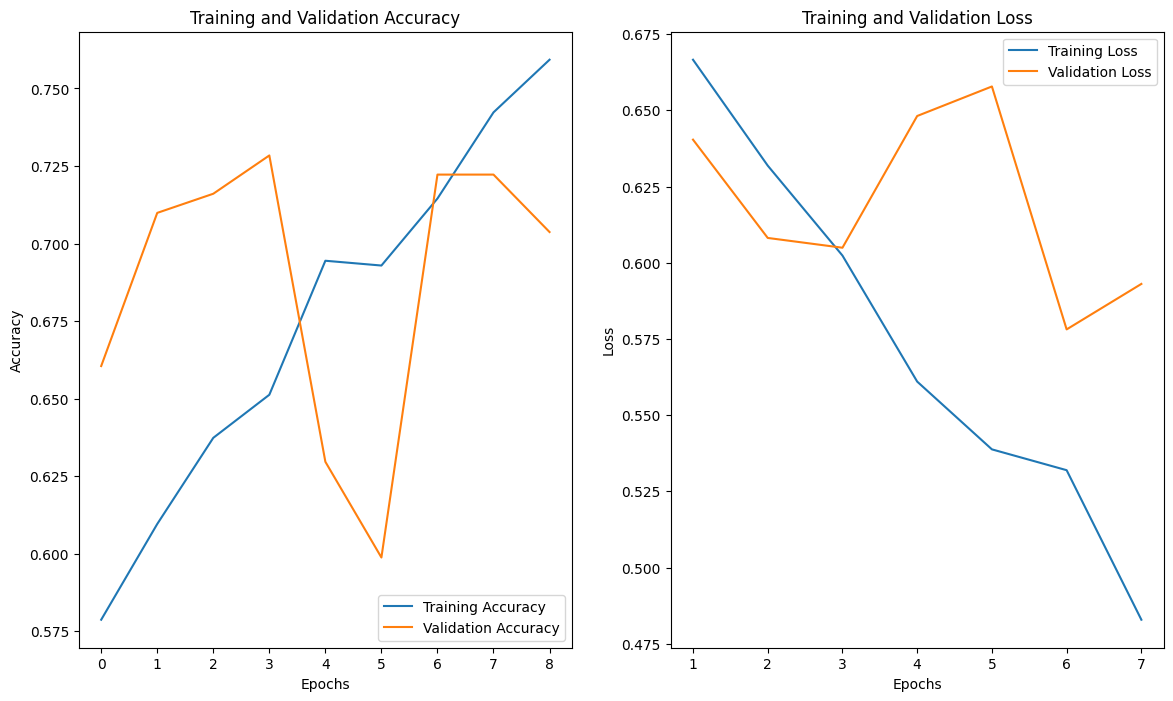

In [21]:
fg_size=(14,8)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epch)

plt.figure(figsize=fg_size)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)
plt.plot(epochs_range[1:-1], loss[1:-1], label='Training Loss')
plt.plot(epochs_range[1:-1], val_loss[1:-1], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

6/6 - 2s - loss: 0.5956 - accuracy: 0.7037 - 2s/epoch - 386ms/step
Loss: 0.5955573916435242 Accuracy: 0.7037037014961243


### BEST EPOCH

In [23]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

6/6 - 2s - loss: 0.5781 - accuracy: 0.7222 - 2s/epoch - 404ms/step
Loss: 0.5781208276748657 Accuracy: 0.7222222089767456


In [24]:
performance_d={'NAME':mdl,
               'ACCURACY':test_accuracy,
               'LOSS':test_loss,
               'HEIGHT':HEIGHT,
               'WIDTH':WIDTH}

performance_d

{'NAME': 'video_conv3D',
 'ACCURACY': 0.7222222089767456,
 'LOSS': 0.5781208276748657,
 'HEIGHT': 160,
 'WIDTH': 160}

# VALIDATION DATA

In [25]:
predictions = model.predict(X_eval)
print(predictions)



6/6 [==============================] - 2s 362ms/step
[[0.47809285]
 [0.47824907]
 [0.24858345]
 [0.25337252]
 [0.507787  ]
 [0.53768134]
 [0.4452614 ]
 [0.50105244]
 [0.15169072]
 [0.4940904 ]
 [0.4790784 ]
 [0.57927686]
 [0.12104297]
 [0.19575131]
 [0.88307405]
 [0.18678664]
 [0.3318742 ]
 [0.9997022 ]
 [0.42969444]
 [0.4585872 ]
 [0.25209805]
 [0.9974955 ]
 [0.47715205]
 [0.4067316 ]
 [0.11827677]
 [0.20244065]
 [0.24782285]
 [0.97074026]
 [0.4962061 ]
 [0.45950183]
 [0.15440106]
 [0.48688856]
 [0.98816067]
 [0.3036201 ]
 [0.477787  ]
 [0.25511226]
 [0.48399127]
 [0.41962925]
 [0.5312526 ]
 [0.34955943]
 [0.47483632]
 [0.50753736]
 [0.53390384]
 [0.54495895]
 [0.9151648 ]
 [0.46134922]
 [0.99247545]
 [0.49352148]
 [0.22325411]
 [0.44935992]
 [0.56837875]
 [0.32425028]
 [0.41520947]
 [0.52981055]
 [0.52138484]
 [0.53613985]
 [0.41993198]
 [0.5010397 ]
 [0.4482542 ]
 [0.5678401 ]
 [0.34162256]
 [0.61713177]
 [0.9942391 ]
 [0.4817688 ]
 [0.6507056 ]
 [0.44388974]
 [0.11042128]
 [0.54064

## ROC CURVE

In [26]:

fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)

roc_auc_false = auc(fpr_val, tpr_val)
roc_auc_thresholds = auc(thresholds_val, tpr_val)

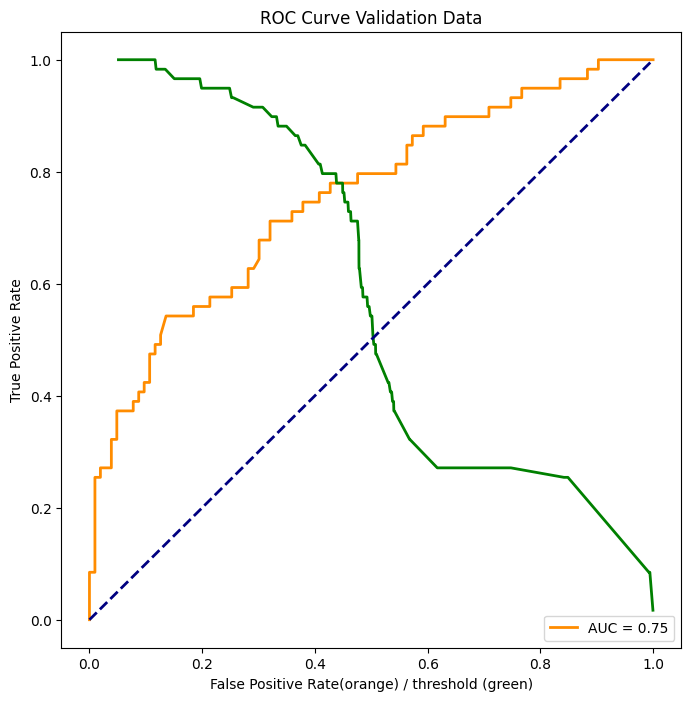

In [27]:
plt.figure(figsize=(8, 8))

plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'AUC = {roc_auc_false:.2f}')
plt.plot(thresholds_val, tpr_val, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate(orange) / threshold (green)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation Data')
plt.legend(loc='lower right')
plt.show()

#  FORECAST EVALUATION

In [28]:
predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [29]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[42 61]
 [ 8 51]]
Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.84      0.41      0.55       103
         1.0       0.46      0.86      0.60        59

    accuracy                           0.57       162
   macro avg       0.65      0.64      0.57       162
weighted avg       0.70      0.57      0.57       162



In [30]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [31]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]
print(correct_labels_val)

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]


In [32]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


OK, 93
BAD, 69
Ratio forecast: 1.3478260869565217
Ratio labeling: 1.7457627118644068


## SINGLE FORECAST

In [33]:
rec_elm=['I1','I28','I70','109897_1','670615_10']
idx_list=[]
for element in rec_elm:
    idx_list.append(recs.index(element))

label_list=y_train[idx_list]
print(idx_list,label_list)

[786, 527, 650, 598, 486] [1. 0. 0. 0. 0.]


In [34]:
idx_val=round((1-test_size)*len(y_train))+1
print(f'data lengh: {len(y_train)} , idx validation start: {idx_val} ')
print(f' Record: {rec_elm} , index: {idx_list}, real label: {label_list}')

data lengh: 810 , idx validation start: 649 
 Record: ['I1', 'I28', 'I70', '109897_1', '670615_10'] , index: [786, 527, 650, 598, 486], real label: [1. 0. 0. 0. 0.]


In [35]:
nuevo_video = np.expand_dims(X_eval[max(idx_list)-idx_val], axis=0)

# Realizar la predicción
prediccion = model.predict(nuevo_video)
prediccion

1/1 [==============================] - 0s 49ms/step


array([[0.501154]], dtype=float32)